In [1]:
!pip install pycaret
!pip install imbalanced-learn
!pip install optuna lightgbm
!pip install duckdb

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import random
import lightgbm as lgb
import requests
import sys
import optuna
import duckdb as dd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.feature_selection import RFE
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope
from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, predict_model
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        pass# Suppress warnings by not doing anything pass

    def error(self, message):
        self.logger.error(message)
# Register the custom logger
lgb.register_logger(CustomLogger())

In [4]:
# connect to personal google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# define function to download file from google drive
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7'
destination = 'term-deposit-marketing-2020.csv'
download_file_from_google_drive(file_id, destination)
df=pd.read_csv(destination)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [6]:
conn = dd.connect()

In [7]:
# filter df for subcribers only
subscribed_df = conn.execute('''
    SELECT *
    FROM df
    WHERE y = 'yes'
    LIMIT 5
      ''').fetchdf()
subscribed_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,yes
1,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,yes
4,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,yes


# Data Analysis

In [8]:
# check for missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [9]:
# check data types
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [10]:
print(df.describe())
print(df.describe(include=['object']))

                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000
                job  marital  education default housing   loan   contact  \
count         40000    40000      40000   40000   40000  40000     40000   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
fre

In [11]:
# filter df for subscribed
subscribed_df = conn.execute('''
    SELECT *
    FROM df
    WHERE y = 'yes'
    LIMIT 5
      ''').fetchdf()

# get statistical summary for continuous features
print('subscribed:')
print(subscribed_df.describe())

# filter df for unsubscribed
not_subscribed_df = conn.execute('''
    SELECT *
    FROM df
    WHERE y = 'no'
    LIMIT 5
      ''').fetchdf()

# get statistical summary for continuous features
print('not subscribed:')
print(not_subscribed_df.describe())

subscribed:
             age      balance  day     duration  campaign
count   5.000000     5.000000  5.0     5.000000  5.000000
mean   53.000000  1263.600000  5.0  1030.000000  1.200000
std     6.964194  1149.519595  0.0   403.374516  0.447214
min    41.000000    45.000000  5.0   579.000000  1.000000
25%    54.000000   184.000000  5.0   673.000000  1.000000
50%    55.000000  1270.000000  5.0  1042.000000  1.000000
75%    56.000000  2343.000000  5.0  1389.000000  1.000000
max    59.000000  2476.000000  5.0  1467.000000  2.000000
not subscribed:
             age      balance  day    duration  campaign
count   5.000000     5.000000  5.0    5.000000       5.0
mean   43.000000   736.200000  5.0  155.600000       1.0
std    10.511898  1018.746632  0.0   76.336754       0.0
min    33.000000     1.000000  5.0   76.000000       1.0
25%    33.000000     2.000000  5.0   92.000000       1.0
50%    44.000000    29.000000  5.0  151.000000       1.0
75%    47.000000  1506.000000  5.0  198.000000     

In [12]:
#  get statistical summary for categorical features
print('subscribed:')
print(subscribed_df.describe(include=object))
print('not subscribed:')
print(not_subscribed_df.describe(include=object))

subscribed:
          job  marital  education default housing loan  contact month    y
count       5        5          5       5       5    5        5     5    5
unique      3        1          2       1       2    1        1     1    1
top     admin  married  secondary      no     yes   no  unknown   may  yes
freq        3        5          4       5       3    5        5     5    5
not subscribed:
               job  marital  education default housing loan  contact month   y
count            5        5          5       5       5    5        5     5   5
unique           5        2          3       1       2    2        1     1   1
top     management  married  secondary      no     yes   no  unknown   may  no
freq             1        3          2       5       4    4        5     5   5


In [13]:
# list unique values and counts
for column in df.columns:
    unique_values = df[column].value_counts()
    print(f"Value counts in column '{column}':")
    print(unique_values)
    print("\n")

Value counts in column 'age':
age
32    1909
31    1826
33    1770
34    1730
35    1721
      ... 
90       1
94       1
86       1
95       1
81       1
Name: count, Length: 70, dtype: int64


Value counts in column 'job':
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64


Value counts in column 'marital':
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64


Value counts in column 'education':
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64


Value counts in column 'default':
default
no     39191
yes      809
Name: count, dtype: int64


Value counts in column 'balance':
balance
 0         3209
 1          179
 2          141
 4          126
 3 

# Phase 1:  Determine customers that are more like to buy the investment product.

## Data Wrangling

In [14]:
# replace yes, no with 1 and 0
df.replace(['no', 'yes'], [0,1], inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [15]:
# create a month number column
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Apply the mapping to the 'month' column
df['month_number'] = df['month'].map(month_map)
# Remove month column
df.drop('month', axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,y,month_number
0,58,management,married,tertiary,0,2143,1,0,unknown,5,261,1,0,5
1,44,technician,single,secondary,0,29,1,0,unknown,5,151,1,0,5
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,0,5
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,0,5
4,33,unknown,single,unknown,0,1,0,0,unknown,5,198,1,0,5


In [16]:
#split data between target 'Y' and variables 'X'
X = df.drop('y',axis=1)
Y = df['y']
print(Y)
print(X.head())

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64
   age           job  marital  education  default  balance  housing  loan  \
0   58    management  married   tertiary        0     2143        1     0   
1   44    technician   single  secondary        0       29        1     0   
2   33  entrepreneur  married  secondary        0        2        1     1   
3   47   blue-collar  married    unknown        0     1506        1     0   
4   33       unknown   single    unknown        0        1        0     0   

   contact  day  duration  campaign  month_number  
0  unknown    5       261         1             5  
1  unknown    5       151         1             5  
2  unknown    5        76         1             5  
3  unknown    5        92         1             5  
4  unknown    5       198         1             5  


In [17]:
# Split data out customer related data
X_customer_cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']
X_customer_raw = X[X_customer_cols]
X_customer_raw.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


## Data Visualization

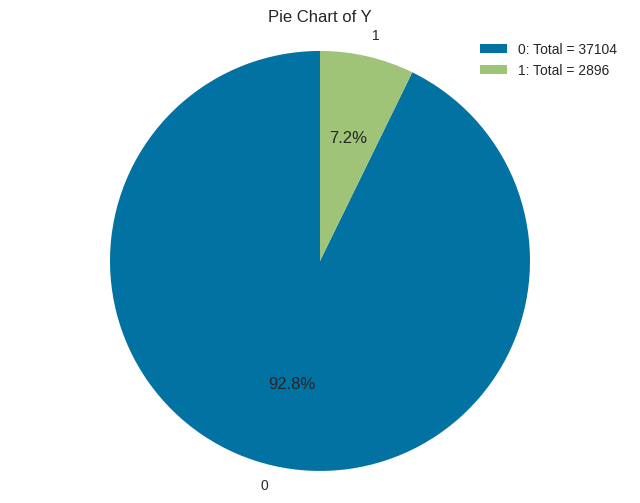

In [18]:
# Replace this with your actual data and labels
y_counts = df['y'].value_counts()
labels = y_counts.index
sizes = y_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


#### Pie chart shows highly imbalance data with ~ 93% unsubsribed



### Subscription status by categorical features

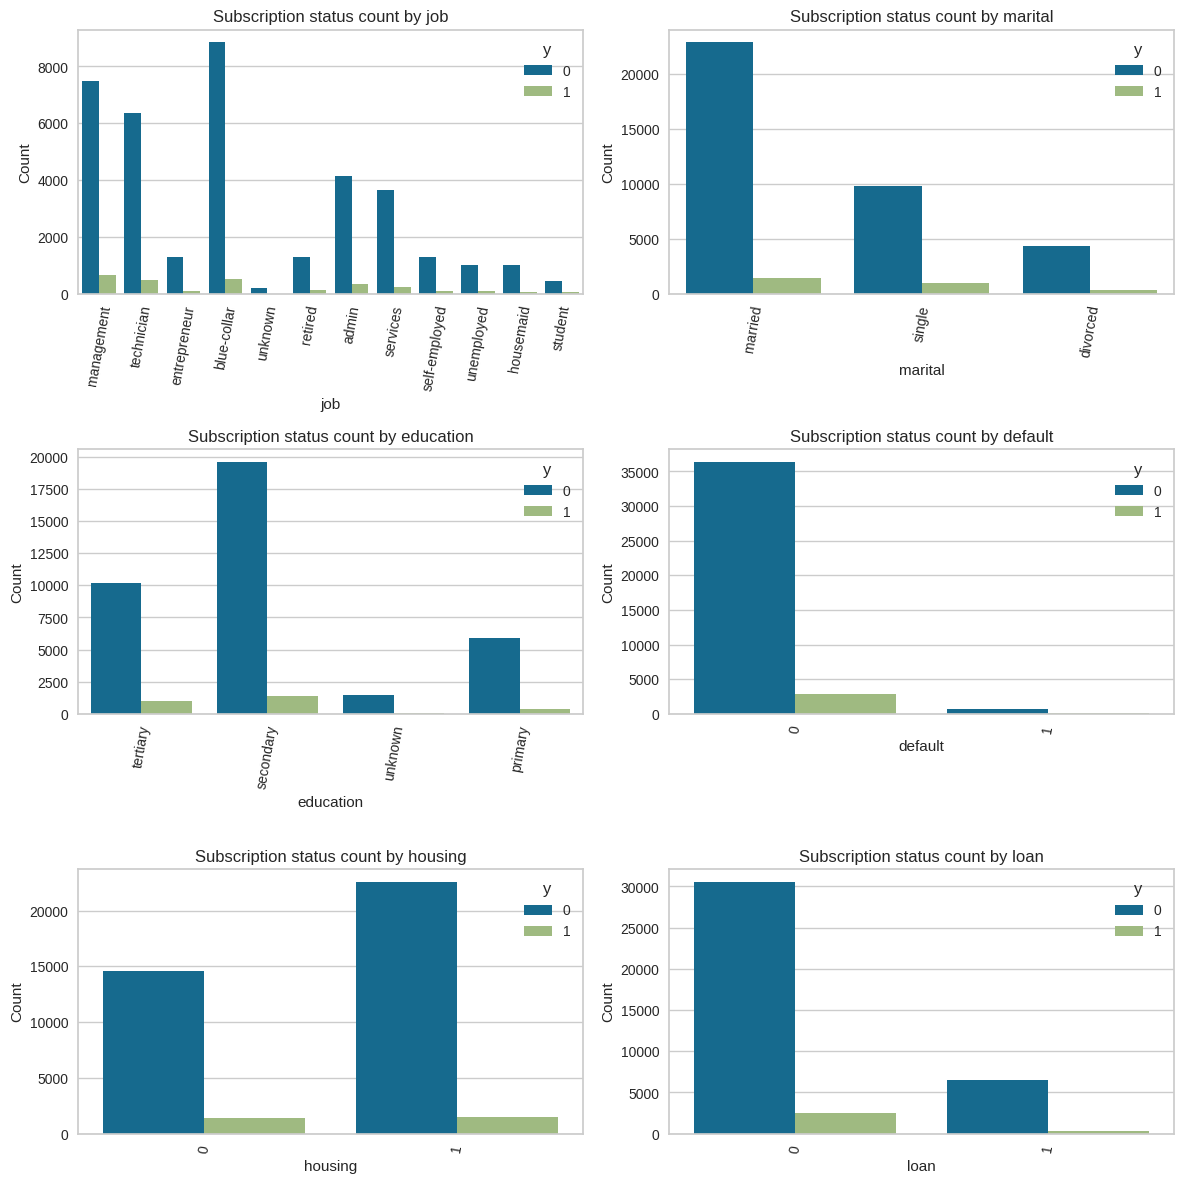

In [19]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['job', 'marital', 'education', 'default', 'housing', 'loan']):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Subscription status count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Subscription status by continous features

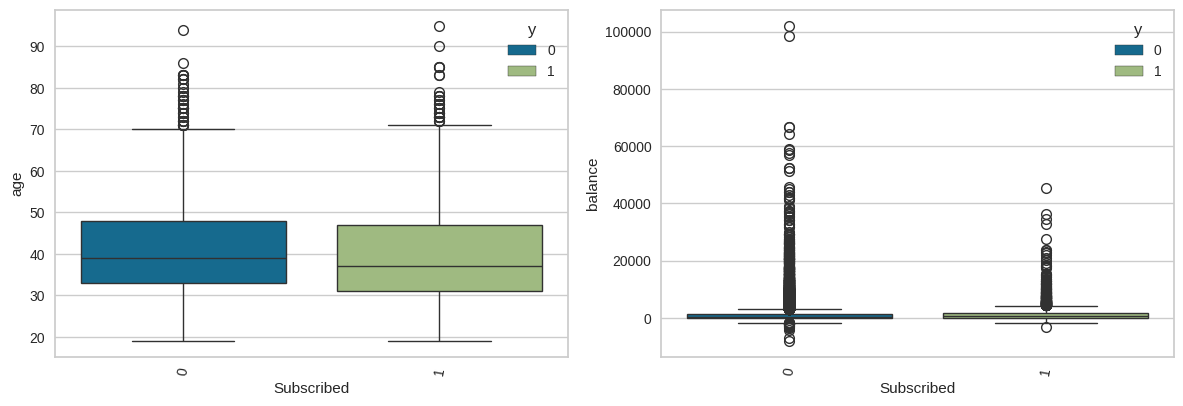

In [20]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['age', 'balance']):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=col, x='y', data=df, hue='y')
    plt.xlabel('Subscribed')
    plt.ylabel(col)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## Data rebalancing

In [21]:
X_customer_raw

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0
...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,0,395,0,0
39996,30,management,single,tertiary,0,3340,0,0
39997,54,admin,divorced,secondary,0,200,0,0
39998,34,management,married,tertiary,0,1047,0,0


In [22]:
# convert categorical columns with one hot encoding
X_customer = pd.get_dummies(data=X_customer_raw, columns=(['job', 'marital', 'education']), drop_first=True)

# scaling of continous features
continous_cols = ['age', 'balance']
transform = preprocessing.StandardScaler()
X_customer[continous_cols] = transform.fit_transform(X_customer[continous_cols])
# convert binary values to float type
X_customer = X_customer.astype(float)
X_customer.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,1.810415,0.0,0.299174,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.358382,0.0,-0.428854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.782501,0.0,-0.438152,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.669532,0.0,0.079802,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.782501,0.0,-0.438497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [23]:
# convert target values to float type

Y = Y.astype(float)
Y.head()

,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [24]:
# good seeds 4134
# seed = random.randint(1000,9999)
seed = 4134
print(seed)

4134


In [25]:
# Splitting training and testing sets before rebalancing to preserve
X_train, X_test, y_train, y_test = train_test_split(X_customer,Y, test_size=0.2, random_state=seed)
print(f'X_train shape:',X_train.shape)
print(f'y_train shape:',y_train.shape)
print(f'X_test shape:',X_test.shape)
print(f'y_test shape:',y_test.shape)

X_train shape: (32000, 21)
y_train shape: (32000,)
X_test shape: (8000, 21)
y_test shape: (8000,)


### Method 1:  Random Undersampler

In [26]:
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f'X_train resample:',X_rus.shape)
print(f'y_train resample:',y_rus.shape)

X_train resample: (4636, 21)
y_train resample: (4636,)


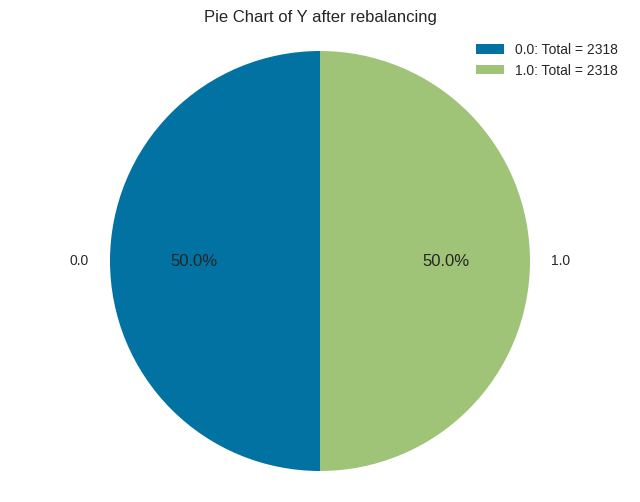

In [27]:
# Replace this with your actual data and labels
y_rus_counts = y_rus.value_counts()
labels = y_rus_counts.index
sizes = y_rus_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with RUS



In [28]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_rus, pd.DataFrame(y_rus, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,4134
1,Target,y
2,Target type,Binary
3,Original data shape,"(4636, 22)"
4,Transformed data shape,"(4636, 22)"
5,Transformed train set shape,"(3245, 22)"
6,Transformed test set shape,"(1391, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5840,0.6192,0.5515,0.5900,0.5694,0.1680,0.1686,0.3100
ada,Ada Boost Classifier,0.5818,0.6109,0.5527,0.5869,0.5690,0.1637,0.1641,0.1660
lr,Logistic Regression,0.5806,0.6040,0.5527,0.5855,0.5682,0.1612,0.1616,1.4620
ridge,Ridge Classifier,0.5784,0.6039,0.5508,0.5831,0.5661,0.1569,0.1573,0.0320
lda,Linear Discriminant Analysis,0.5781,0.6039,0.5496,0.5829,0.5653,0.1563,0.1567,0.0340
rf,Random Forest Classifier,0.5667,0.5872,0.5588,0.5675,0.5629,0.1334,0.1336,0.4300
et,Extra Trees Classifier,0.5612,0.5726,0.5607,0.5615,0.5609,0.1224,0.1225,0.4200
qda,Quadratic Discriminant Analysis,0.5562,0.5879,0.2902,0.6328,0.3909,0.1127,0.1377,0.0340
knn,K Neighbors Classifier,0.5547,0.5757,0.5379,0.5565,0.5468,0.1094,0.1095,0.1220
xgboost,Extreme Gradient Boosting,0.5544,0.5745,0.5484,0.5549,0.5510,0.1088,0.1091,0.1660


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5950,0.6166,0.5363,0.0945,0.1606,0.0430,0.0715


### Method 2:  SMOTE-ENN

In [29]:
sme = SMOTEENN(random_state=seed)
X_sme, y_sme = sme.fit_resample(X_train, y_train)
print(f'X_train resample:',X_sme.shape)
print(f'y_train resample:',y_sme.shape)

X_train resample: (38297, 21)
y_train resample: (38297,)


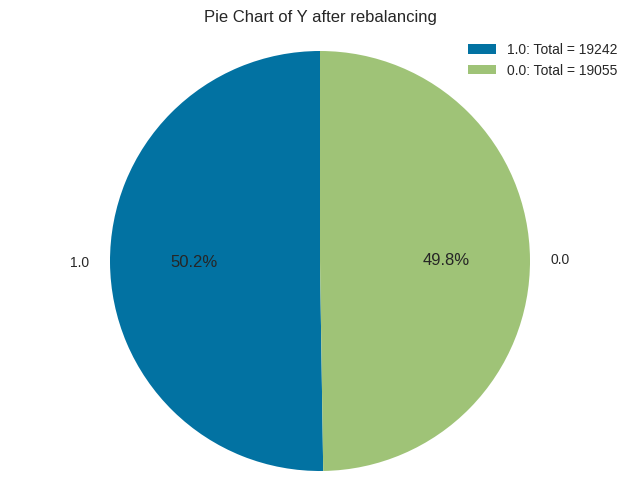

In [30]:
# Replace this with your actual data and labels
y_sme_counts = y_sme.value_counts()
labels = y_sme_counts.index
sizes = y_sme_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with SMOTE-ENN

In [31]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_sme, pd.DataFrame(y_sme, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,4134
1,Target,y
2,Target type,Binary
3,Original data shape,"(38297, 22)"
4,Transformed data shape,"(38297, 22)"
5,Transformed train set shape,"(26807, 22)"
6,Transformed test set shape,"(11490, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9754,0.9963,0.9732,0.9778,0.9755,0.9508,0.9509,2.5380
rf,Random Forest Classifier,0.9573,0.9903,0.9495,0.9649,0.9571,0.9145,0.9146,3.4820
lightgbm,Light Gradient Boosting Machine,0.9241,0.9712,0.8822,0.9637,0.9211,0.8482,0.8514,2.3220
xgboost,Extreme Gradient Boosting,0.9145,0.9699,0.8773,0.9487,0.9116,0.8291,0.8315,0.5460
dt,Decision Tree Classifier,0.9048,0.9048,0.9104,0.9012,0.9058,0.8097,0.8097,0.2000
knn,K Neighbors Classifier,0.9046,0.9701,0.9366,0.8811,0.9080,0.8092,0.8108,1.3020
gbc,Gradient Boosting Classifier,0.7928,0.8797,0.7811,0.8017,0.7912,0.5857,0.5859,2.7240
ada,Ada Boost Classifier,0.6973,0.7758,0.6991,0.6990,0.6989,0.3946,0.3948,0.6980
lr,Logistic Regression,0.6297,0.6731,0.6219,0.6342,0.6279,0.2595,0.2596,0.1280
ridge,Ridge Classifier,0.6283,0.6725,0.6193,0.6330,0.6260,0.2566,0.2567,0.1140


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7592,0.5962,0.3304,0.1104,0.1655,0.0641,0.0774


### Method 3:  SMOTE-Tomek

In [32]:
smt = SMOTETomek(random_state=seed)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
print(f'X_train resample:',X_smt.shape)
print(f'y_train resample:',y_smt.shape)

X_train resample: (55674, 21)
y_train resample: (55674,)


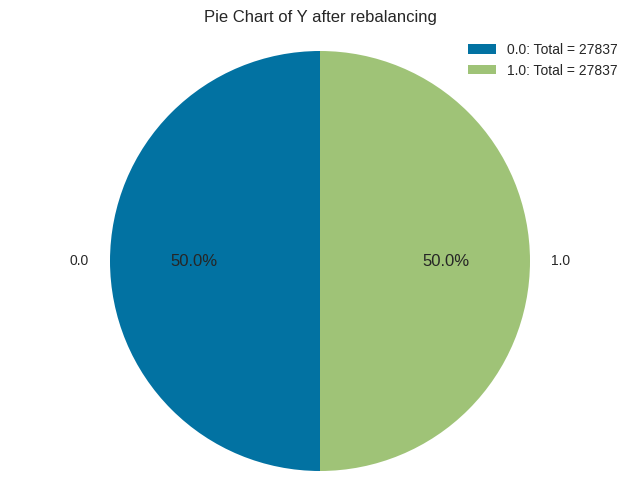

In [33]:
# Replace this with your actual data and labels
y_smt_counts = y_smt.value_counts()
labels = y_smt_counts.index
sizes = y_smt_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with SMOTE-Tomek

In [34]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_smt, pd.DataFrame(y_smt, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,4134
1,Target,y
2,Target type,Binary
3,Original data shape,"(55674, 22)"
4,Transformed data shape,"(55674, 22)"
5,Transformed train set shape,"(38971, 22)"
6,Transformed test set shape,"(16703, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9049,0.9518,0.8276,0.9789,0.8969,0.8098,0.8196,5.7620
et,Extra Trees Classifier,0.8935,0.9527,0.8923,0.8944,0.8933,0.7869,0.7870,4.6120
dt,Decision Tree Classifier,0.8859,0.8866,0.8859,0.8859,0.8859,0.7718,0.7718,0.4560
rf,Random Forest Classifier,0.8830,0.9487,0.8754,0.8889,0.8821,0.7660,0.7661,6.8860
xgboost,Extreme Gradient Boosting,0.8747,0.9395,0.8041,0.9363,0.8652,0.7494,0.7570,0.8120
knn,K Neighbors Classifier,0.7961,0.8725,0.8655,0.7599,0.8093,0.5921,0.5979,2.9600
gbc,Gradient Boosting Classifier,0.7694,0.8554,0.7488,0.7811,0.7646,0.5389,0.5394,3.8400
ada,Ada Boost Classifier,0.6533,0.7216,0.6822,0.6451,0.6628,0.3066,0.3074,1.1320
lr,Logistic Regression,0.5915,0.6229,0.5949,0.5909,0.5928,0.1830,0.1830,0.2040
ridge,Ridge Classifier,0.5914,0.6229,0.5949,0.5908,0.5928,0.1828,0.1829,0.0900


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9144,0.6091,0.1073,0.2684,0.1533,0.1168,0.1306


## Predictive Analysis

In [35]:
# define a confusion matrix plotter for visualizing classification report results
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['not subsribed', 'subscribed']); ax.yaxis.set_ticklabels(['not subsribed', 'subscribed'])
    plt.show()

## Extra Trees Classifier with Smote-ENN balanced data





Number of finished trials: 100
Best trial parameters: {'n_estimators': 76, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'sqrt'}
Best trial value: 0.1869772998805257
                precision    recall  f1-score   support

Not Subscribed       0.95      0.67      0.78      7422
    Subscribed       0.11      0.54      0.19       578

      accuracy                           0.66      8000
     macro avg       0.53      0.61      0.49      8000
  weighted avg       0.89      0.66      0.74      8000



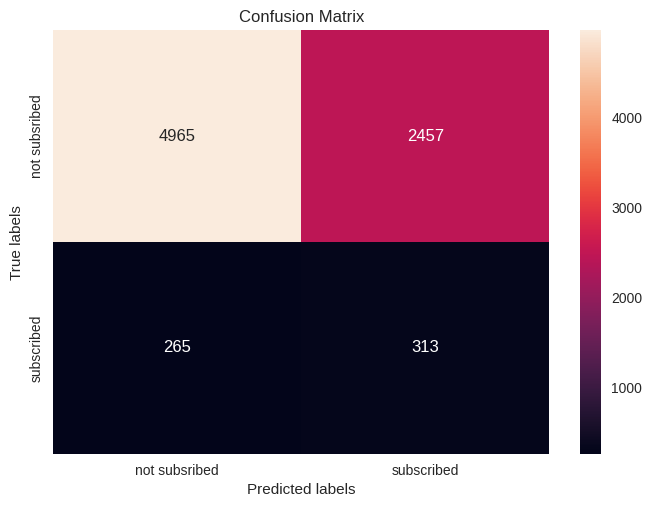

In [36]:
# optimizing Extra trees classfier with optuna.  Class weight set to balanced to adjust class weights.

optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])

    model = ExtraTreesClassifier(
        class_weight='balanced',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=seed
    )
    model.fit(X_sme, y_sme)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials:", len(study.trials))
print("Best trial parameters:", study.best_trial.params)
print("Best trial value:", study.best_trial.value)

best_params_et = study.best_trial.params
et_best = ExtraTreesClassifier(**best_params_et, class_weight='balanced', random_state=seed)
et_best.fit(X_sme, y_sme)
y_pred = et_best.predict(X_test)

report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)
plot_confusion_matrix(y_test, y_pred)

## Customer segmentation

In [48]:
X_test.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
28553,-1.508517,0.0,-0.317618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
13490,0.773249,0.0,-0.509440,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
36755,0.047233,0.0,1.471803,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
25714,1.395549,0.0,-0.305909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2556,1.084399,0.0,-0.279391,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [44]:
# Splitting training and testing sets before rebalancing to preserve
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X,Y, test_size=0.2, random_state=seed)
X_test_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,month_number
28553,26,student,single,secondary,0,352,0,0,cellular,29,202,2,1
13490,48,technician,married,secondary,0,-205,1,1,cellular,9,112,1,7
36755,41,management,single,secondary,0,5548,1,0,cellular,12,128,2,5
25714,54,services,married,unknown,0,386,0,1,cellular,19,74,1,11
2556,51,technician,married,secondary,0,463,1,0,unknown,13,213,5,5


In [61]:
# add y_pred to X using X index

df_pred = X_test_raw

df_pred['y_pred'] = y_pred

df_pred.head()



,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,month_number,y_pred
28553,26,student,single,secondary,0,352,0,0,cellular,29,202,2,1,1.0
13490,48,technician,married,secondary,0,-205,1,1,cellular,9,112,1,7,0.0
36755,41,management,single,secondary,0,5548,1,0,cellular,12,128,2,5,0.0
25714,54,services,married,unknown,0,386,0,1,cellular,19,74,1,11,0.0
2556,51,technician,married,secondary,0,463,1,0,unknown,13,213,5,5,0.0


In [64]:
# filter df for subscribed
predicted_sub = conn.execute('''
    SELECT *
    FROM df_pred
    WHERE y_pred = 1
    LIMIT 5
      ''').fetchdf()

predicted_sub.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,month_number,y_pred
0,26,student,single,secondary,0,352,0,0,cellular,29,202,2,1,1.0
1,30,management,single,tertiary,0,0,0,0,cellular,29,135,2,8,1.0
2,51,admin,married,secondary,0,0,0,0,telephone,20,96,5,11,1.0
3,55,retired,married,secondary,0,168,0,0,cellular,19,79,2,8,1.0
4,30,blue-collar,single,secondary,0,191,0,0,cellular,25,66,2,7,1.0


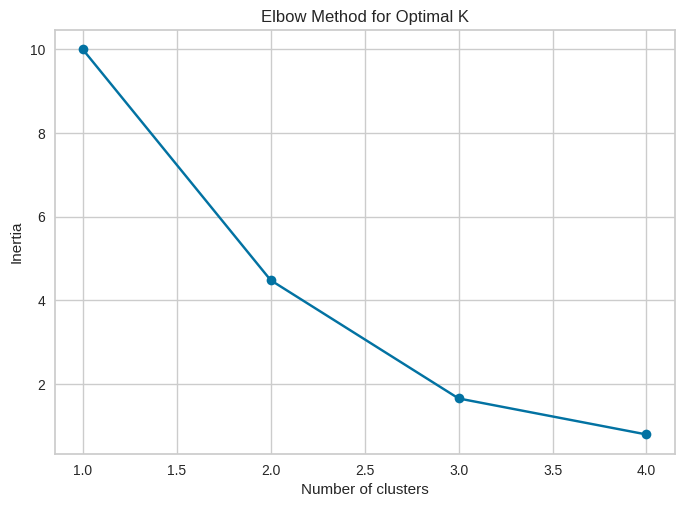

In [73]:
# Select relevant features for clustering
features_for_clustering = ['age', 'balance']  # You can add more features if needed
X_cluster = predicted_sub[features_for_clustering]

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Determine the optimal number of clusters using the elbow method (optional)
n_samples = X_cluster_scaled.shape[0]
inertia = []
for i in range(1, min(11, n_samples)):  # Limit clusters to less than or equal to number of samples
    kmeans = KMeans(n_clusters=i, random_state=seed)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, min(11, n_samples)), inertia, marker='o') #update range for plot
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



          age  default  balance  housing  loan   day  duration  campaign  \
cluster                                                                    
0        30.0      0.0      0.0      0.0   0.0  29.0     135.0       2.0   
1        53.0      0.0     84.0      0.0   0.0  19.5      87.5       3.5   
2        28.0      0.0    271.5      0.0   0.0  27.0     134.0       2.0   

         month_number  y_pred  
cluster                        
0                 8.0     1.0  
1                 9.5     1.0  
2                 4.0     1.0  


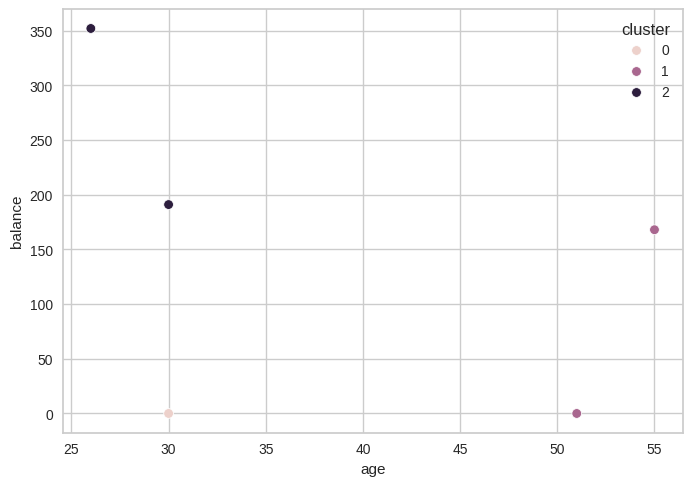

   age          job  marital  education  default  balance  housing  loan  \
0   26      student   single  secondary        0      352        0     0   
1   30   management   single   tertiary        0        0        0     0   
2   51        admin  married  secondary        0        0        0     0   
3   55      retired  married  secondary        0      168        0     0   
4   30  blue-collar   single  secondary        0      191        0     0   

     contact  day  duration  campaign  month_number  y_pred  cluster  
0   cellular   29       202         2             1     1.0        2  
1   cellular   29       135         2             8     1.0        0  
2  telephone   20        96         5            11     1.0        1  
3   cellular   19        79         2             8     1.0        1  
4   cellular   25        66         2             7     1.0        2  


In [76]:
# Based on the elbow method or other analysis, choose the number of clusters
n_clusters = 3  # Replace with the optimal number of clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(X_cluster_scaled)

# Add cluster labels to the DataFrame
predicted_sub['cluster'] = kmeans.labels_

# Select only numeric columns for calculating the mean
numeric_predicted_sub = predicted_sub.select_dtypes(include=np.number)

print(numeric_predicted_sub.groupby('cluster').mean()) # Calculate mean for numeric columns only

# You can also visualize the clusters using scatter plots or other methods.
# For example:
sns.scatterplot(x='age', y='balance', hue='cluster', data=predicted_sub)
plt.show()

print(predicted_sub.head())
